## Setup

In [28]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import random
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Fill in the path where you downloaded the project or if the hole folder is open, leave it as it is. 
# Should print what in your folder is.
ROOT_PATH = '.'
print(os.listdir(ROOT_PATH))

['data', 'Simulaiton01_housing_visual.ipynb', 'Simulaiton02_housig_rf.ipynb', 'Simulation03_friedman_unbalanced.ipynb', 'Simulation04_friedman_balanced.ipynb', 'Stratificaiton.ipynb', 'utils.py', 'utils_Nadja.py', '__pycache__']


In [29]:
from utils import generate_friedman1, to_dataframe, plot_data_3D, train_test_stratified, evaluate_rf

## Generate Friedman1 dataset

In [64]:
features, y = generate_friedman1(n_samples=1000)
(features, y)

(array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
        [0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258],
        [0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497],
        ...,
        [0.1531445 , 0.72811644, 0.60025141, 0.73125059, 0.76974662],
        [0.97541037, 0.57356328, 0.34164111, 0.64846456, 0.06844071],
        [0.89739732, 0.11938101, 0.32784284, 0.81574538, 0.59731238]]),
 array([16.83826156, 12.51782504,  5.86968919,  7.53187897,  9.45737165,
        10.88906915, 21.29818121, 19.26769898, 16.61008184, 12.44163815,
        22.83735821,  6.46236702, 10.38662987,  9.88601081, 21.21547558,
        17.60207288, 12.69134012, 18.39401421, 13.47560394,  8.14785175,
        10.94077686,  7.1379749 , 16.40332854, 21.67042684, 10.53641573,
        14.12700131, 13.85231999, 14.34693947, 11.33172011,  2.61396215,
        18.66039324, 12.27788144, 12.83883023, 12.78596049,  5.84676689,
        14.00663761, 14.88326076, 16.4903815 , 13.8271

In [65]:
df=to_dataframe(features=features, y=y)
df

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.838262
1,0.155995,0.058084,0.866176,0.601115,0.708073,12.517825
2,0.020584,0.969910,0.832443,0.212339,0.181825,5.869689
3,0.183405,0.304242,0.524756,0.431945,0.291229,7.531879
4,0.611853,0.139494,0.292145,0.366362,0.456070,9.457372
...,...,...,...,...,...,...
995,0.446726,0.123450,0.205980,0.000943,0.039265,3.658595
996,0.977284,0.242354,0.663311,0.839100,0.550660,18.450667
997,0.153145,0.728116,0.600251,0.731251,0.769747,14.794133
998,0.975410,0.573563,0.341641,0.648465,0.068441,17.154440


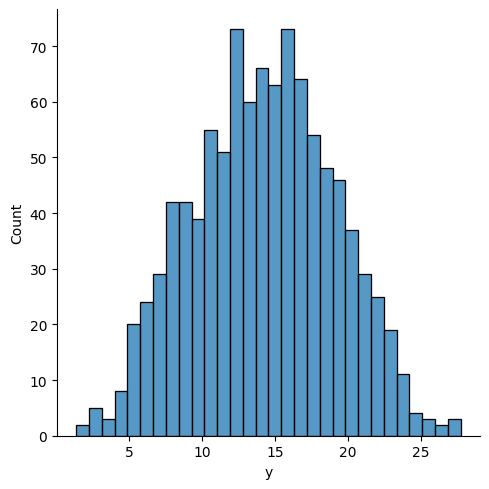

In [66]:
sns.displot(df, x='y', bins = 30)

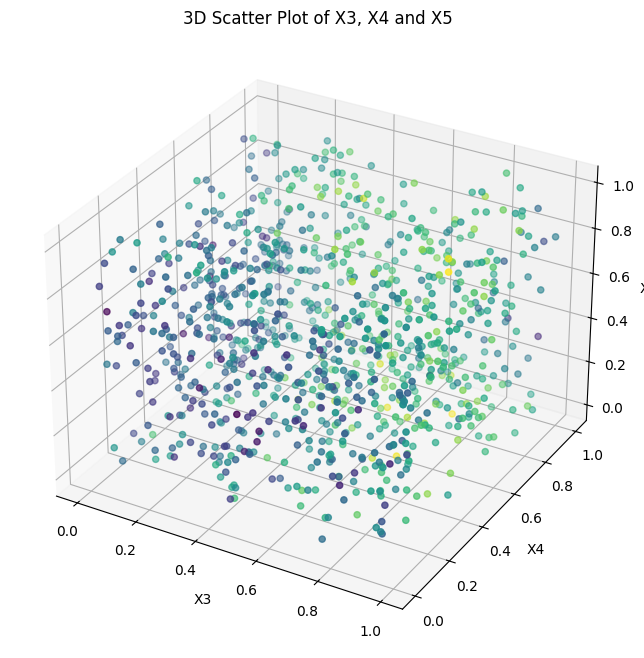

In [67]:
plot_data_3D(df, ['X3', 'X4','X5'])

### What if we add noise??

In [68]:
features_noise, y_noise = generate_friedman1(noise=10)
df_noise=to_dataframe(features_noise, y_noise)
df_noise

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.647628
1,0.155995,0.058084,0.866176,0.601115,0.708073,24.590708
2,0.020584,0.969910,0.832443,0.212339,0.181825,12.122614
3,0.183405,0.304242,0.524756,0.431945,0.291229,-0.515011
4,0.611853,0.139494,0.292145,0.366362,0.456070,27.328506
...,...,...,...,...,...,...
9995,0.532481,0.550056,0.984144,0.599966,0.666627,28.648759
9996,0.213723,0.106865,0.602010,0.864880,0.587373,8.005824
9997,0.442783,0.578207,0.468772,0.141882,0.741184,29.699039
9998,0.533038,0.399323,0.559639,0.241227,0.427958,-1.211299


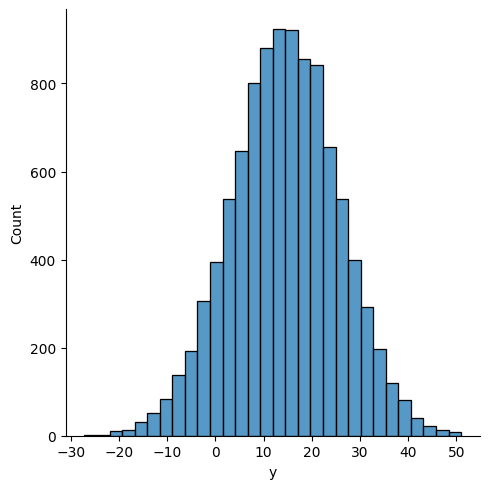

In [69]:
sns.displot(df_noise, x='y', bins = 30)

-> It doesn't really make it imbalanced, but standard deviation becomes larger.

## Random Forest, no stratification, 5-fold cv, random search

In [70]:
# first devide data in train/test data (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[: , :-1], df['y'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 5) (200, 5) (800,) (200,)


In [71]:
# Define the parameter grid for random search
param_rf = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}

In [72]:
# Initialize Random Forest model
rf_model=RandomForestRegressor(random_state=42)
                            

In [73]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_rf,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)


In [74]:
# Perform the random search on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found by random search
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [75]:
# Display the cross-validated score with the best parameters
best_score = random_search.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")



Best Cross-Validated Mean Squared Error: -3.8212


In [76]:
def evaluate_rf(model, X_train, X_test, y_train, y_test, cv_rs=True):
    if cv_rs:
        model=model.best_estimator_
    train_r2, test_r2=model.score(X_train, y_train), model.score(X_test, y_test)
    y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
    train_mse, test_mse=mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)
    #print(f"Train Set R^2 Score: {train_r2:.4f} \nTest Set R^2 Score: {test_r2:.4f} \n Train Set MSE Score: {train_mse:.4f} \nTest Set MSE Score: {test_mse:.4f}")
    return {'train r2': train_r2, 
            'test r2': test_r2, 
            'train mse': train_mse,
            'test mse': test_mse}

In [77]:
# Evaluate the model with the best parameters on the test set
score=evaluate_rf(random_search, X_train, X_test, y_train, y_test)
score

{'train r2': 0.9116441254490691,
 'test r2': 0.8713349562553522,
 'train mse': 2.016015131481109,
 'test mse': 3.104442938711747}

## Random Forest, Stratification, 5-fold cv, random search

@Anne: why create data agian? Use on same one

In [96]:
features, y = generate_friedman1(n_samples=10000)
df=to_dataframe(features=features, y=y)

In [99]:
np.histogram(df['y'], bins='doane')  

(array([  39,  168,  417,  633,  968, 1221, 1428, 1422, 1294,  974,  744,
         432,  194,   50,   16], dtype=int64),
 array([ 1.04236923,  2.91850644,  4.79464365,  6.67078086,  8.54691807,
        10.42305528, 12.29919249, 14.1753297 , 16.05146691, 17.92760412,
        19.80374133, 21.67987854, 23.55601575, 25.43215296, 27.30829017,
        29.18442738]))

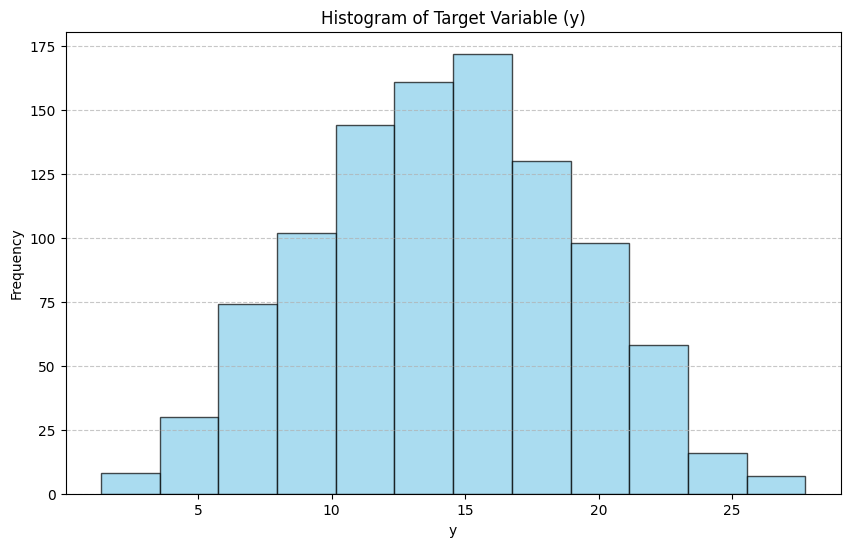

In [78]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['y'], bins='doane', color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Target Variable (y)')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

Approach with quantiles. In this case with 20 5% quantiles to sample randomly 80% from each one. 

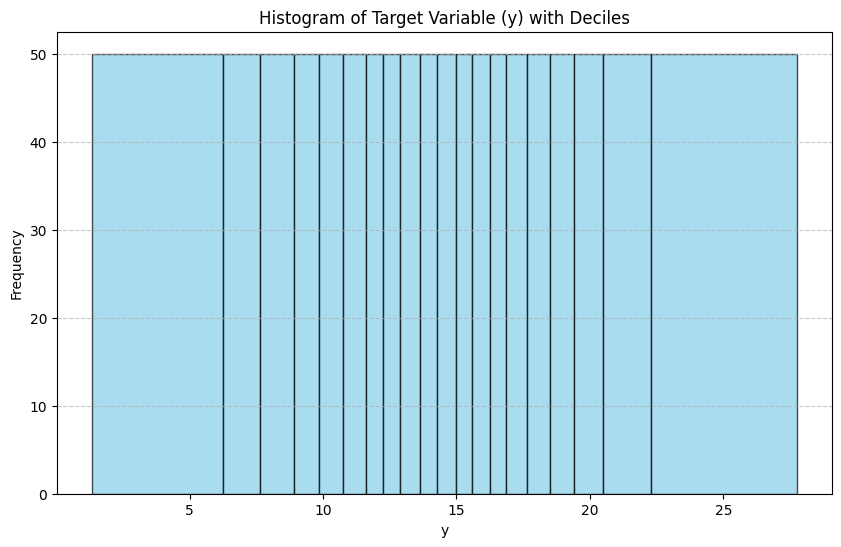

In [79]:
# Calculate decile values
quantiles = [np.percentile(df['y'], i) for i in range(0, 101, 5)]

# Plot the histogram with decile values
plt.figure(figsize=(10, 6))
plt.hist(df['y'], bins=quantiles, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Target Variable (y) with Deciles')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [44]:
from utils import train_test_stratified

In [80]:

def train_test_stratified2(df, n_quantiles=20, train_size=0.8, seed=42):
    # Step 1: Sort the DataFrame based on the target variable
    #df_sorted = df.sort_values(by='y')
    # Step 2: Divide the sorted DataFrame into deciles
    quantiles = pd.qcut(df['y'], q=n_quantiles, labels=False)
    # Step 3: Randomly sample 80% of the data from each decile for training
    train_data = pd.concat([group.sample(frac=train_size, random_state=seed) for _, group in df.groupby(quantiles)])
    # The remaining 20% will be used for testing
    test_data = df.drop(train_data.index)
    train_data = shuffle(train_data)
    test_data = shuffle(test_data)
    # Step 4: Already divide by features and target variables
    X_train, y_train = train_data.drop(columns=['y']), train_data['y']
    X_test, y_test = test_data.drop(columns=['y']), test_data['y']
    return X_train, X_test, y_train, y_test

In [81]:
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_stratified2(df=df)

In [82]:
# Verify the sizes of the train and test sets
print("Train set size:", X_train_strat.shape, y_train_strat.shape)
print("Test set size:", X_test_strat.shape, y_test_strat.shape)

Train set size: (800, 5) (800,)
Test set size: (200, 5) (200,)


@Anne: initalize random search, I think otherwise continue training old random search model ?

In [83]:
# Initialize Random Forest model
rf_model_strat=RandomForestRegressor(random_state=42)
# Define the parameter grid for random search
param_rf_strat = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}
# Initialize RandomizedSearchCV
random_search_strat = RandomizedSearchCV(estimator=rf_model_strat, param_distributions=param_rf_strat,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

In [84]:
# Perform the random search on the training set
random_search_strat.fit(X_train_strat, y_train_strat)

# Display the best parameters found by random search
print("Best Parameters:", random_search_strat.best_params_)

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [85]:
# Display the cross-validated score with the best parameters
best_score_strat = random_search_strat.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")


Best Cross-Validated Mean Squared Error: -3.8212


In [86]:
# Evaluate the model with the best parameters on the test set
score_strat=evaluate_rf(random_search_strat, X_train_strat, X_test_strat, y_train_strat, y_test_strat)

In [87]:
score_strat

{'train r2': 0.9129489825137787,
 'test r2': 0.8682444145102757,
 'train mse': 2.048462435758663,
 'test mse': 2.975136507232968}

Metrics from training without stratification: 

{'train r2': 0.9116441254490691,
 'test r2': 0.8713349562553522,
 'train mse': 2.016015131481109,
 'test mse': 3.104442938711747}

## Try without cross validation

In [126]:
rf_baseline=RandomForestRegressor(n_estimators=882, min_samples_split=14, min_samples_leaf=8, max_features=4, random_state=42)

In [127]:
rf_baseline.fit(train_data.drop(columns=['y']), train_data['y'])

RandomForestRegressor(max_features=4, min_samples_leaf=8, min_samples_split=14,
                      n_estimators=882, random_state=42)

In [134]:
# Evaluate the model with the best parameters on the test set
train_score_base=rf_baseline.score(train_data.drop(columns=['y']), train_data['y'])
test_score_base = rf_baseline.score(test_data.drop(columns=['y']), test_data['y'])
print(f"Train Set R^2 Score: {train_score_base:.4f} \nTest Set R^2 Score: {test_score_base:.4f}")

Train Set R^2 Score: 0.9664 
Test Set R^2 Score: 0.9401


# Include stratification also in cross-validation

This is for general cross-validation without stratification.

In [132]:
41:42

SyntaxError: illegal target for annotation (1772441787.py, line 1)

In [138]:
y_train

29      2.613962
535    10.860213
695    13.499402
557    22.996127
836    12.000466
         ...    
106    19.883439
270    19.761135
860    13.667462
435    16.614475
102    19.847020
Name: y, Length: 800, dtype: float64

In [136]:
df['y']

0      16.838262
1      12.517825
2       5.869689
3       7.531879
4       9.457372
         ...    
995     3.658595
996    18.450667
997    14.794133
998    17.154440
999    15.039252
Name: y, Length: 1000, dtype: float64

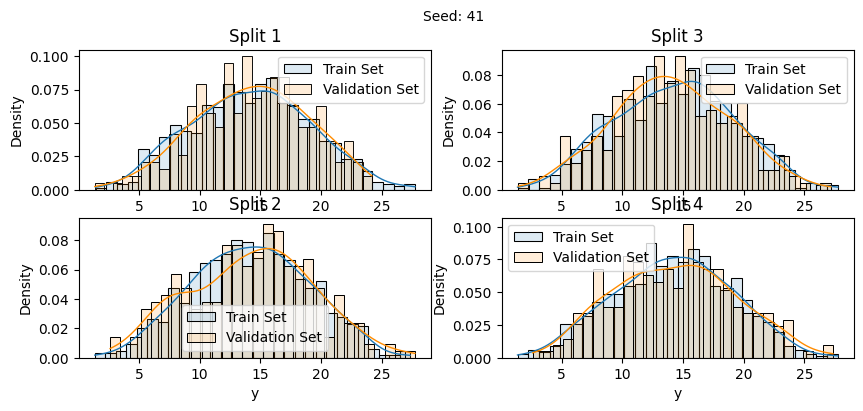

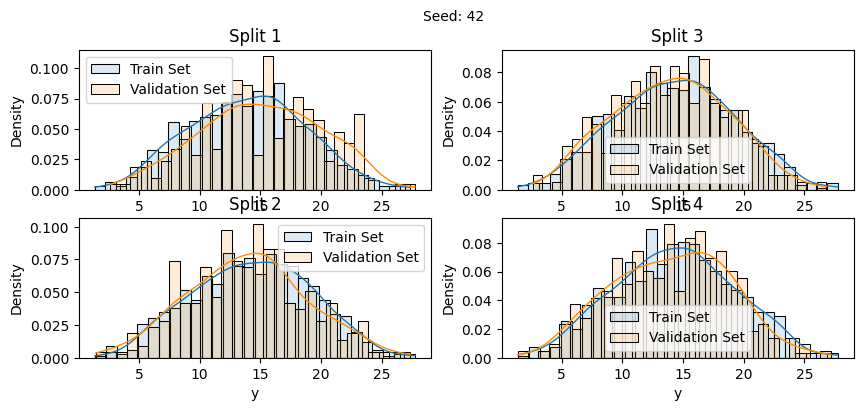

In [141]:
from sklearn.model_selection import KFold
from utils_Nadja import fold_visualizer
labels = df['y']


for i in [41, 42]:
    baseline_kfold = list(KFold(4,
                                shuffle=True,
                                random_state=i
                               ).split(labels))
    fold_visualizer(data=labels,
                    fold_idxs=baseline_kfold,
                    seed_num=i)

In [126]:
from sklearn.model_selection import StratifiedKFold
def create_cont_folds(y, n_folds=5, n_goups=5, seed=1):
    # create StratifiedKFold like for classification
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # create groups in y with pd.qcut: quantile-based discretization 
    y_grouped = pd.qcut(y, n_goups, labels=False)

    # create fold numbers    
    fold_nums = np.zeros(len(y))
    #split(X, y[, groups]): Generate indices to split data into training and test set
    for fold_no, (t, v) in enumerate(skf.split(y_grouped, y_grouped)): #@Nadja: unabhängig von n_folds? n_folds = fol_no, test_data_size = N/n_folds
        fold_nums[v] = fold_no
  

    cv_splits = []

    # iterate over folds and creat train and test indices for each fold
    for i in range(n_folds):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(y_grouped))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))

    return cv_splits

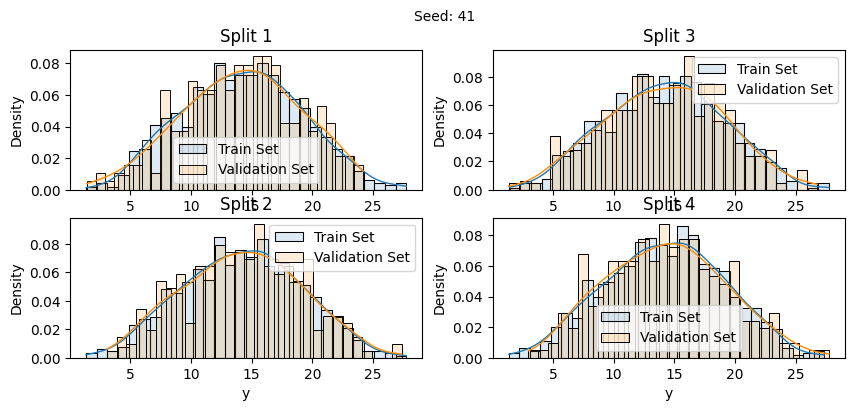

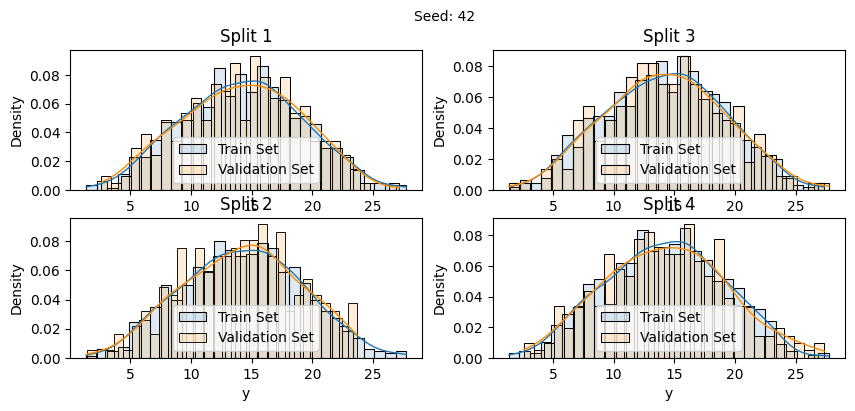

In [142]:
num_of_folds = 4
num_of_groups = 10

for i in [41, 42]:
    cv_splits = create_cont_folds(labels, n_folds=num_of_folds, n_goups=num_of_groups, seed=i)
    fold_visualizer(data=labels,
                    fold_idxs=cv_splits,
                    seed_num=i)

In [128]:
n_folds=4
n_goups=10
labels = y_train_strat ### @Nadja: problem labels within function not defined

#cv splits
cv_splits_training = create_cont_folds(labels, n_folds=n_folds, n_goups=n_goups, seed=1)

# Initialize Random Forest model
rf_model_stratified=RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_stratified = RandomizedSearchCV(estimator=rf_model_stratified, param_distributions=param_rf,
                                   n_iter=10, cv = cv_splits_training, scoring='neg_mean_squared_error', random_state=42)

In [117]:
# check that cv splits worked correctly
test_dat=[]
for index, value in enumerate(cv_splits_training):
    test_dat.extend(value[1])
num_unique_numbers = len(set(test_dat))
print(f"Number of unique numbers: {num_unique_numbers}")

In [129]:
# Perform the random search on the training set
random_search_stratified.fit(X_train_strat, y_train_strat) 

# Display the best parameters found by random search
print("Best Parameters:", random_search_stratified.best_params_)

# Display the cross-validated score with the best parameters
best_score_stratified = random_search_stratified.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")

Best Parameters: {'n_estimators': 661, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 2}

Best Cross-Validated Mean Squared Error: -3.8212


In [130]:
score_stratified=evaluate_rf(random_search_stratified, X_train_strat, X_test_strat, y_train_strat, y_test_strat)

In [131]:
score_stratified

{'train r2': 0.9067008199567823,
 'test r2': 0.8678208297939709,
 'train mse': 2.195492610248544,
 'test mse': 2.984701356789062}

In [ ]:
{'train r2': 0.9116441254490691,
 'test r2': 0.8713349562553522,
 'train mse': 2.016015131481109,
 'test mse': 3.104442938711747}

In [ ]:
{'train r2': 0.9129489825137787,
 'test r2': 0.8682444145102757,
 'train mse': 2.048462435758663,
 'test mse': 2.975136507232968}